In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Define Data Loader

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "qa", logger=logger)
df_table_origin = data_loader.load_dialogue_df()


# Define OOD Categories below

In [5]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

tqdm.pandas()

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

category = "animal"
logger.info(f"Processing OOD Category: {category}")
ood_category = [category]
ind_category = [x for x in data_loader.supercategories if x not in ood_category]

df_table = df_table_origin.copy()
df_table['OOD'] = df_table['supercategory'].apply(lambda x: 0 if any(item in x for item in ood_category) else 1)
df_table['OOD'].value_counts()

if data_loader.data_source == "real":
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
    image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
    image_annotation.rename(columns={0:"image_clip"}, inplace=True)
    df_table = df_table.merge(image_annotation, on='img_file', how='left')

elif data_loader.data_source == "qa":
    dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_dialogs_truncate/qa_clip_dialog_features.npy')
    df_table['dialogue_clip'] = list(dialogue_clip)
    df_table['image_file'] = df_table['image_id'].astype('str') + '.jpg'
    image_clip = np.load(f'{data_loader.data_dir}/CLIP/qa_imgs/qa_clip_img_features.npy')
    image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/qa_imgs/all_img_names.json')
    image_annotation = image_annotation.rename(columns={0:"image_file"})
    image_annotation['image_clip'] = list(image_clip)
    df_table = df_table.merge(image_annotation, on='image_file', how='left') 

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategory']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

logger.info(f"Calculating Similarity Scores")
categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'
    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)
    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
#dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = (df_table['image_score_max'] + df_table['dialogue_score_max'])
df_table['overall_simialrity_sum'] = (df_table['image_score'] + df_table['dialogue_score'])
df_table['overall_simialrity_transform'] = 4 * df_table['image_text_similarity'] * df_table['overall_simialrity']
df_table['overall_simialrity_sum_transform'] = 4 * df_table['image_text_similarity'] * df_table['overall_simialrity_sum']

image_model_loader = model.model_loader(logger=logger,
                                num_epochs=6,
                                learning_rate=0.001,
                                proportion = 0.8,
                                seed = 20)

dialogue_model_loader = model.model_loader(logger=logger,
                                num_epochs=6,
                                learning_rate=0.001,
                                seed = 20)

(
df_ind_train, 
df_test, 
X_train_image, 
X_test_image, 
X_train_dialogue, 
X_test_dialogue, 
Y_train, 
Y_test) = image_model_loader.create_dataset(data_loader, df_table, add_mismatch = False, mismatch_num = 10000)

df_test['image_text_similarity'] = df_test.apply(image_text_similarity, axis=1)
image_model_loader.train_model(X_train_image, Y_train, X_test_image, Y_test, ood_category = '_'.join(ood_category))
dialogue_model_loader.train_model(X_train_dialogue, Y_train, X_test_dialogue, Y_test, ood_category = '_'.join(ood_category))


2024-05-19 18:07:50,951 - notebook_logger - INFO - Processing OOD Category: animal
2024-05-19 18:08:05,458 - notebook_logger - INFO - Calculating Similarity Scores


  0%|          | 0/122218 [00:00<?, ?it/s]

  0%|          | 0/122218 [00:00<?, ?it/s]

2024-05-19 18:08:26,714 - notebook_logger - INFO - Setting random seed: 20
2024-05-19 18:08:26,724 - notebook_logger - INFO - Setting random seed: 20
100%|██████████| 6/6 [00:35<00:00,  5.88s/it]
2024-05-19 18:09:02,975 - notebook_logger - INFO - Model saved at /Users/xuetongwu/Documents/GitHub/multimodal_ood/models/DNN/models/DNN/image_model_animal_6_0.001.pth
100%|██████████| 6/6 [00:37<00:00,  6.30s/it]
2024-05-19 18:09:40,934 - notebook_logger - INFO - Model saved at /Users/xuetongwu/Documents/GitHub/multimodal_ood/models/DNN/models/DNN/image_model_animal_6_0.001.pth


In [11]:
score_type_list = ["prob", "energy", "logits", "msp", "odin", "mahalanobis"]

for score_type in score_type_list:
    if score_type != "mahalanobis":
        image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True)
        dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True)

    else:
        image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True,
                                                            X_train=X_train_image,
                                                            Y_train=Y_train)
        dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                            Y_test,
                                                            score_type=score_type,\
                                                            return_score=True,
                                                            X_train=X_train_dialogue,
                                                            Y_train=Y_train)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_max_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_image'] 
    df_test[f'{score_type}_max_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_sum_image_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_image']
    df_test[f'{score_type}_sum_dialogue_tranform'] = 4 * df_test['image_text_similarity'] * df_test[f'{score_type}_sum_dialogue']
    df_test[f'{score_type}_overall_simialrity_max'] = df_test[f'{score_type}_max_image'] + df_test[f'{score_type}_max_dialogue']
    df_test[f'{score_type}_overall_simialrity_max_transform'] =  df_test[f'{score_type}_max_image_tranform'] + df_test[f'{score_type}_max_dialogue_tranform']
    if score_type in ["energy", "logits", "prob", "odin", "mahalanobis"]:
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test[f'{score_type}_sum_image'] + df_test[f'{score_type}_sum_dialogue']
        df_test[f'{score_type}_overall_simialrity_sum_transform'] = df_test[f'{score_type}_sum_image_tranform'] + df_test[f'{score_type}_sum_dialogue_tranform']


# Initialize lists to store data
metrics = []
values = []
scores = [] 

def eval_dict(score):
    return {
        "FPR": lambda x: ev.fpr_evaluation(x['OOD'].values, x[score].values, 0.95),
        "AUROC": lambda x: ev.auroc_evaluation(x['OOD'].values, x[score].values),
        "AUPR": lambda x: ev.aupr_evaluation(x['OOD'].values, x[score].values)
    }

# Define the metrics and corresponding functions
metric_functions = {
    "Max Cosine": {
        "Image": eval_dict('image_score_max'),
        "Dialogue": eval_dict('dialogue_score_max'),
        "Overall": eval_dict('overall_simialrity'),
        "Overall_Transform": eval_dict('overall_simialrity_transform')
    },
    "Sum Cosine": {
        "Image": eval_dict('image_score'),
        "Dialogue": eval_dict('dialogue_score'),
        "Overall": eval_dict('overall_simialrity_sum'),

        "Overall_Transform": eval_dict('overall_simialrity_sum_transform')
    },
    "Energy Sum": {
        "Image": eval_dict('energy_sum_image'),
        "Dialogue": eval_dict('energy_sum_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_sum_transform')
    },
    "Energy Max": {
        "Image": eval_dict('energy_max_image'),
        "Dialogue": eval_dict('energy_max_dialogue'),
        "Overall": eval_dict('energy_overall_simialrity_max'),
        "Overall_Transform": eval_dict('energy_overall_simialrity_max_transform')
    },
    "MSP": {
        "Image": eval_dict('msp_max_image'),
        "Dialogue": eval_dict('msp_max_dialogue'),
        "Overall": eval_dict('msp_overall_simialrity_max'),
        "Overall_Transform": eval_dict('msp_overall_simialrity_max_transform')
    },
    "Max Prob": {
        "Image": eval_dict('prob_max_image'),
        "Dialogue": eval_dict('prob_max_dialogue'),
        "Overall": eval_dict('prob_overall_simialrity_max'),
        "Overall_Transform": eval_dict('prob_overall_simialrity_max_transform')
    },
    "Sum Prob": {
        "Image": eval_dict('prob_sum_image'),
        "Dialogue": eval_dict('prob_sum_dialogue'),
        "Overall": eval_dict('prob_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('prob_overall_simialrity_sum_transform')
    },
    "Max Odin": {
        "Image": eval_dict('odin_max_image'),
        "Dialogue": eval_dict('odin_max_dialogue'),
        "Overall": eval_dict('odin_overall_simialrity_max'),
        "Overall_Transform": eval_dict('odin_overall_simialrity_max_transform')
    },
    "Sum Odin": {
        "Image": eval_dict('odin_sum_image'),
        "Dialogue": eval_dict('odin_sum_dialogue'),
        "Overall": eval_dict('odin_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('odin_overall_simialrity_sum_transform')
    },
    "Max Mahalanobis": {
        "Image": eval_dict('mahalanobis_max_image'),
        "Dialogue": eval_dict('mahalanobis_max_dialogue'),
        "Overall": eval_dict('mahalanobis_overall_simialrity_max'),
        "Overall_Transform": eval_dict('mahalanobis_overall_simialrity_max_transform')
    },
    "Sum Mahalanobis": {
        "Image": eval_dict('mahalanobis_sum_image'),
        "Dialogue": eval_dict('mahalanobis_sum_dialogue'),
        "Overall": eval_dict('mahalanobis_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('mahalanobis_overall_simialrity_sum_transform')
    },
    "Max Logits": {
        "Image": eval_dict('logits_max_image'),
        "Dialogue": eval_dict('logits_max_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_max'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_max_transform')
    },
    "Sum Logits": {
        "Image": eval_dict('logits_sum_image'),
        "Dialogue": eval_dict('logits_sum_dialogue'),
        "Overall": eval_dict('logits_overall_simialrity_sum'),
        "Overall_Transform": eval_dict('logits_overall_simialrity_sum_transform')
    }
}

# Loop through each metric and calculate values
for score, items in metric_functions.items():
    scores.extend([score] * len(items) * 3)
    for metric, funcs in items.items():
        metrics.extend([metric] * len(funcs))
        values.extend([func(df_test) for func in funcs.values()])

# Create DataFrame
df = pd.DataFrame({"Metric": metrics, "Value": values, "Score": scores})
df['Value'] = df['Value'].apply(lambda x: round(x, 3))
#df_grouped = df.groupby('Metric')['Value'].apply(list).reset_index()
result = df.groupby(['Metric', 'Score'])['Value'].agg(list).unstack().transpose()
result_df = result[['Image', 'Dialogue', 'Overall', 'Overall_Transform']]
result_df.reset_index(inplace=True)
order = ['Max Cosine', 
         'Sum Cosine', 
         'Max Prob', 
         'Sum Prob', 
         'Max Logits', 
         'Sum Logits', 
         'Max Odin',
         'Sum Odin',
         'Max Mahalanobis',
         'Sum Mahalanobis',
         'MSP', 
         'Energy Sum', 
         'Energy Max']
result_df = result_df.set_index('Score').loc[order].reset_index()
def convert_to_percentage(lst):
    return ' / '.join(f'{x*100:.1f}' for x in lst)


result_df['Image'] = result_df['Image'].apply(convert_to_percentage)
result_df['Dialogue'] = result_df['Dialogue'].apply(convert_to_percentage)
result_df['Overall'] = result_df['Overall'].apply(convert_to_percentage)
result_df['Overall_Transform'] = result_df['Overall_Transform'].apply(convert_to_percentage)

latex_table = result_df.to_latex(index=False, column_format='|l|c|c|c|c|', header=["Score", "Image", "Dialogue", "Overall", "Overall_Transform"], escape=False)

print(latex_table)

2024-05-19 18:11:45,390 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 18:11:46,078 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 18:11:46,523 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 18:11:46,953 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 18:11:47,416 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 18:11:47,843 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 18:11:48,296 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 18:11:48,784 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 18:11:50,353 - notebook_logger - INFO - Test Loss: 0.1863, Test Accuracy: 0.4457
2024-05-19 18:11:51,825 - notebook_logger - INFO - Test Loss: 0.2589, Test Accuracy: 0.3247
2024-05-19 18:11:53,433 - notebook_logger - INFO - Mahalanobis score calculated 

\begin{tabular}{|l|c|c|c|c|}
\toprule
Score & Image & Dialogue & Overall & Overall_Transform \\
\midrule
Max Cosine & 90.1 / 66.9 / 61.7 & 93.0 / 58.0 / 52.8 & 91.0 / 63.1 / 59.3 & 96.7 / 42.8 / 40.1 \\
Sum Cosine & 93.7 / 57.8 / 52.7 & 93.2 / 57.3 / 51.4 & 92.6 / 59.1 / 53.8 & 96.7 / 41.1 / 38.5 \\
Max Prob & 49.7 / 83.1 / 77.4 & 59.9 / 80.4 / 74.6 & 46.6 / 84.3 / 79.0 & 64.4 / 72.5 / 58.8 \\
Sum Prob & 63.6 / 73.7 / 63.2 & 91.2 / 65.8 / 58.2 & 72.7 / 72.9 / 64.0 & 77.1 / 69.2 / 59.5 \\
Max Logits & 49.7 / 83.1 / 77.4 & 59.9 / 80.4 / 74.6 & 45.7 / 85.0 / 80.4 & 47.6 / 83.6 / 77.6 \\
Sum Logits & 90.1 / 62.0 / 55.2 & 99.7 / 42.3 / 44.2 & 98.1 / 56.1 / 52.4 & 96.2 / 59.0 / 54.3 \\
Max Odin & 48.5 / 82.8 / 76.9 & 65.4 / 80.0 / 73.7 & 48.5 / 83.9 / 78.1 & 69.2 / 72.8 / 59.7 \\
Sum Odin & 64.2 / 73.3 / 62.9 & 91.2 / 64.9 / 57.3 & 72.4 / 72.4 / 63.5 & 79.3 / 68.2 / 58.5 \\
Max Mahalanobis & 93.8 / 54.4 / 52.0 & 96.8 / 52.2 / 49.1 & 96.6 / 54.2 / 51.7 & 96.7 / 52.5 / 49.8 \\
Sum Mahalanobis 

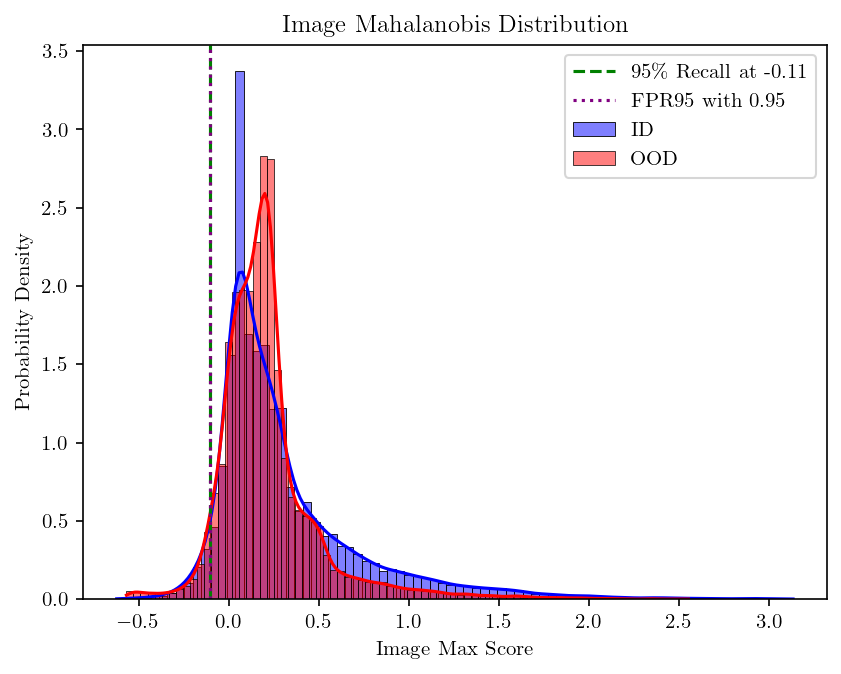

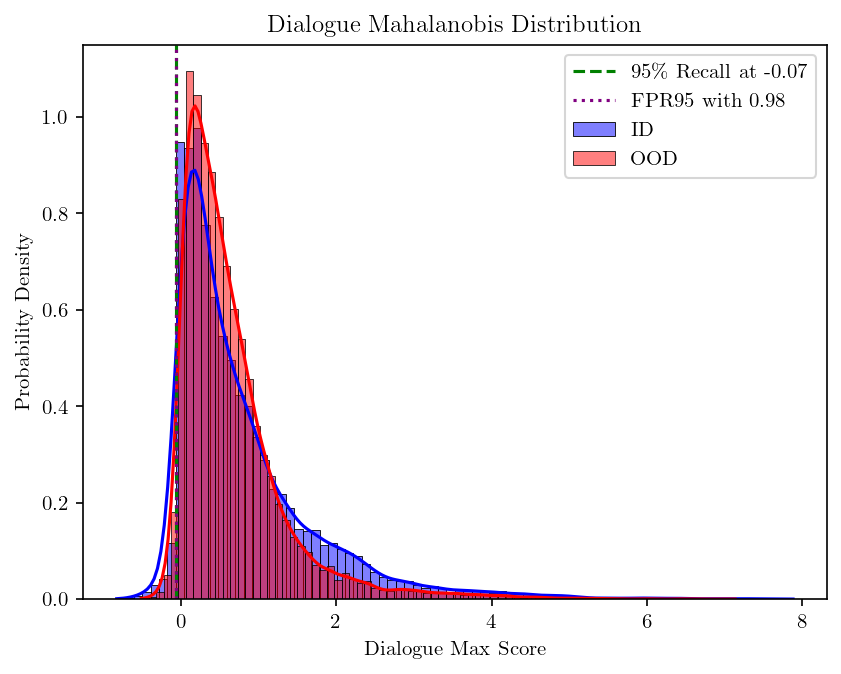

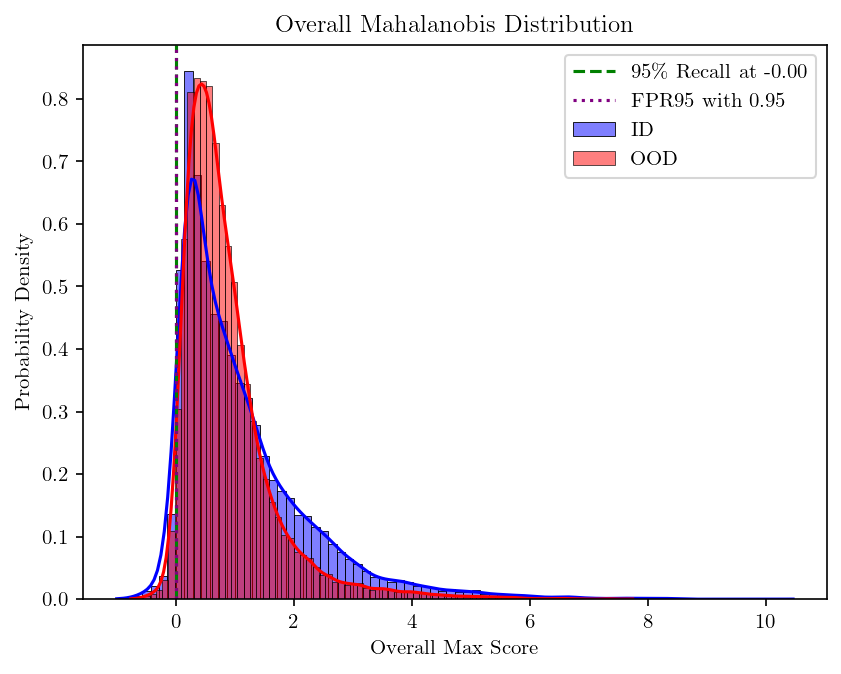

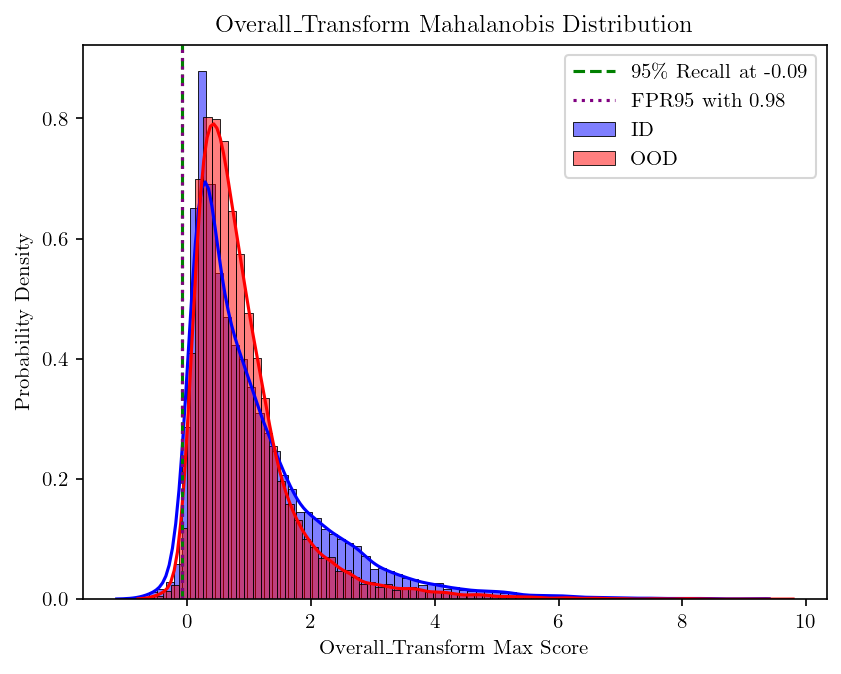

In [12]:
import importlib
from utils import plot_figure
importlib.reload(plot_figure)

score_type = "mahalanobis"
type = "max"
mode = "image"
fpr = 95

plot_figure.plot_score_distribution(df_test, score_type, type, mode="image", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="dialogue", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall", fpr=fpr)
plot_figure.plot_score_distribution(df_test, score_type, type, mode="overall_transform", fpr=fpr)

In [8]:
test = df_test[['odin_overall_simialrity_sum', 'odin_overall_simialrity_max', 'odin_overall_simialrity_sum_transform', 'odin_overall_simialrity_max_transform']]
test

,odin_overall_simialrity_sum,odin_overall_simialrity_max,odin_overall_simialrity_sum_transform,odin_overall_simialrity_max_transform
0,5.280435,1.966162,4.617097,1.719169
1,5.481681,1.477418,6.122102,1.650023
2,4.540436,1.995373,4.695370,2.063462
4,4.833294,1.632235,5.988389,2.022318
5,2.475850,1.046656,2.913993,1.231879
...,...,...,...,...
122203,4.031376,1.523434,2.409719,0.910619
122206,6.399492,1.964856,6.351860,1.950231
122208,1.893354,0.689770,1.951470,0.710943
122209,4.459280,1.980746,4.958810,2.202629


## Results on OOD

# Without Mismatching Pair, Test ID instance 23233, Test OOD instance 6051


## Without image text similarity score
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.32, 0.952, 0.988]  |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.151, 0.974, 0.994] |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.885, 0.657, 0.889] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.331, 0.951, 0.988] |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.507, 0.927, 0.982] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.932, 0.788, 0.943] |

## With image text similarity score overall
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.346, 0.945, 0.986] |
| Energy Sum | [0.236, 0.964, 0.991] | [0.508, 0.935, 0.984] | [0.194, 0.97, 0.993]  |
| MSP        | [0.894, 0.625, 0.873] | [0.919, 0.68, 0.905]  | [0.908, 0.574, 0.846] |
| Max Cosine | [0.877, 0.711, 0.905] | [0.971, 0.54, 0.835]  | [0.964, 0.579, 0.857] |
| Max Logits | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.35, 0.945, 0.986]  |
| Max Prob   | [0.373, 0.937, 0.983] | [0.791, 0.886, 0.972] | [0.731, 0.793, 0.934] |
| Sum Cosine | [0.94, 0.576, 0.84]   | [0.978, 0.494, 0.814] | [0.972, 0.51, 0.817]  |
| Sum Logits | [0.904, 0.762, 0.934] | [0.974, 0.758, 0.931] | [0.955, 0.764, 0.934] |

# With 5000 mismatching pairs, testing ID instance 23233, test OOD isntance 11051


## Without image text similarity
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.614, 0.758, 0.838] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.522, 0.767, 0.843] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.921, 0.598, 0.773] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.619, 0.758, 0.839] |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.707, 0.765, 0.848] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.953, 0.672, 0.814] |

## With imge text similarity score on overall 
| Score      | Image                 | Dialogue              | Overall               |
|:-----------|:----------------------|:----------------------|:----------------------|
| Energy Max | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.598, 0.862, 0.932] |
| Energy Sum | [0.546, 0.762, 0.821] | [0.698, 0.748, 0.819] | [0.511, 0.872, 0.934] |
| MSP        | [0.92, 0.57, 0.737]   | [0.932, 0.604, 0.762] | [0.752, 0.723, 0.831] |
| Max Cosine | [0.908, 0.618, 0.758] | [0.961, 0.523, 0.708] | [0.959, 0.544, 0.724] |
| Max Logits | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.607, 0.86, 0.931]  |
| Max Prob   | [0.625, 0.747, 0.815] | [0.859, 0.721, 0.81]  | [0.569, 0.859, 0.924] |
| Sum Cosine | [0.945, 0.543, 0.712] | [0.965, 0.497, 0.693] | [0.963, 0.506, 0.695] |
| Sum Logits | [0.923, 0.65, 0.783]  | [0.963, 0.648, 0.782] | [0.975, 0.546, 0.709] |






